#07-2025-01-26Certificate Lifecycle Analysis for RAPIDS Project

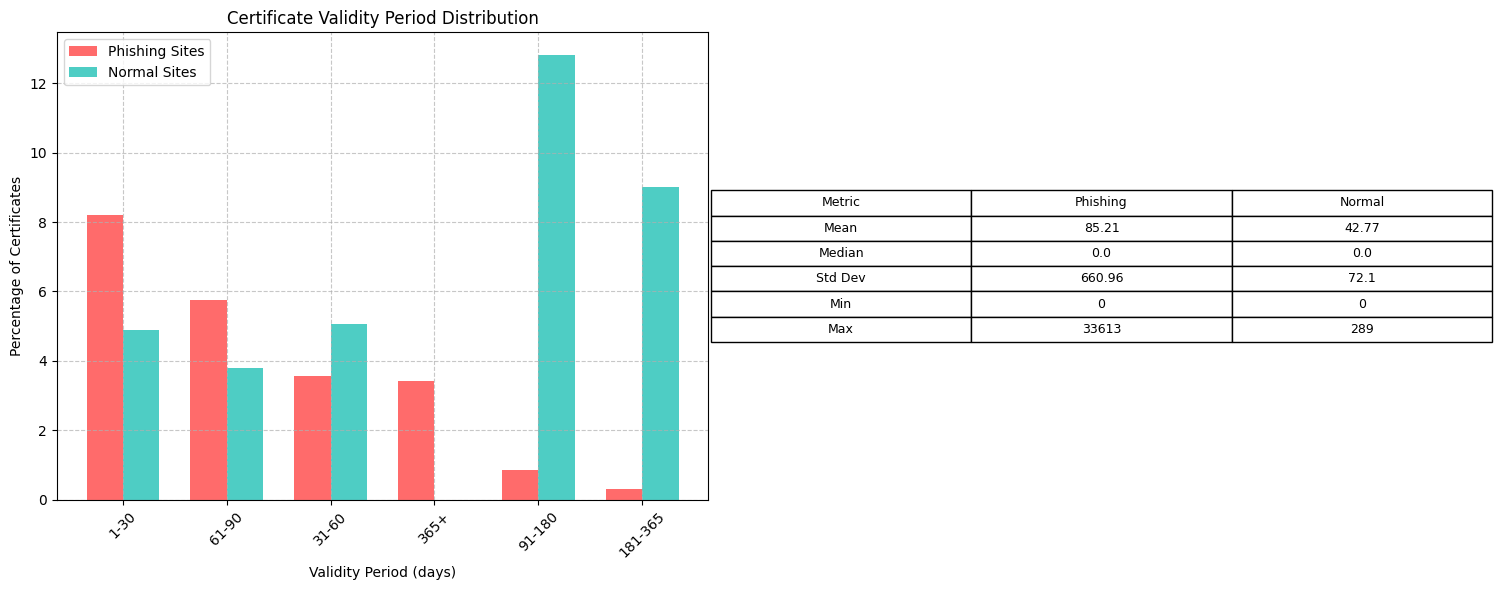

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import json
from pathlib import Path
from datetime import datetime
from typing import Dict, Tuple
from IPython.display import display, clear_output, Markdown

class CertificateValidityAnalyzer:
    """Analyzer for certificate validity period distribution"""

    def __init__(self, config_path: str):
        """
        Initialize the analyzer with database configuration

        Args:
            config_path: Path to the database configuration file
        """
        with open(config_path) as f:
            self.config = json.load(f)['database']

        # Set colors for visualization
        self.colors = {
            'phishing': '#FF6B6B',
            'normal': '#4ECDC4'
        }

    def get_database_connection(self, db_name: str) -> create_engine:
        """Create database connection"""
        host = '192.168.1.92' if db_name == 'website_data' else '192.168.1.92'
        return create_engine(
            f"postgresql://{self.config['user']}:{self.config['password']}@{host}/{db_name}"
        )

    def extract_validity_periods(self, db_name: str) -> pd.Series:
        """
        Extract certificate validity periods from database

        Args:
            db_name: Name of the database to query

        Returns:
            Series containing validity periods in days
        """
        engine = self.get_database_connection(db_name)

        query = """
        SELECT https_certificate_expiry 
        FROM website_data 
        WHERE status = 7 
        AND https_certificate_expiry IS NOT NULL
        """

        df = pd.read_sql_query(query, engine)
        return df['https_certificate_expiry'].apply(self._extract_days)

    def _extract_days(self, expiry_text: str) -> float:
        """Extract number of validity days from expiry text"""
        if pd.isna(expiry_text):
            return np.nan

        # Extract expiry date from the given format (e.g., 20241028073105Z)
        try:
            expiry_date = datetime.strptime(expiry_text, '%Y%m%d%H%M%SZ')
            current_date = datetime.utcnow()
            delta = (expiry_date - current_date).days
            return max(delta, 0)  # Ensure non-negative days
        except Exception as e:
            print(f"Error parsing expiry date: {expiry_text}. Error: {e}")
            return np.nan

    def analyze_validity_distribution(self, validity_days: pd.Series) -> Dict:
        """
        Analyze the distribution of validity periods

        Args:
            validity_days: Series containing validity periods in days

        Returns:
            Dictionary containing analysis results
        """
        # Define bins for analysis
        bins = [0, 30, 60, 90, 180, 365, float('inf')]
        labels = ['1-30', '31-60', '61-90', '91-180', '181-365', '365+']

        # Calculate distribution
        binned = pd.cut(validity_days, bins=bins, labels=labels)
        distribution = binned.value_counts()
        percentage = (distribution / len(validity_days) * 100).round(2)

        return {
            'distribution': distribution.to_dict(),
            'percentage': percentage.to_dict(),
            'statistics': {
                'mean': validity_days.mean(),
                'median': validity_days.median(),
                'std': validity_days.std(),
                'min': validity_days.min(),
                'max': validity_days.max()
            }
        }

    def plot_validity_distribution(self, phishing_results: Dict, normal_results: Dict) -> None:
        """
        Create comparison plots for validity distributions

        Args:
            phishing_results: Analysis results for phishing sites
            normal_results: Analysis results for normal sites
        """
        # Clear previous output
        clear_output(wait=True)

        # Create figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Prepare data for plotting
        categories = list(phishing_results['percentage'].keys())
        phishing_pct = [phishing_results['percentage'].get(cat, 0) for cat in categories]
        normal_pct = [normal_results['percentage'].get(cat, 0) for cat in categories]

        # Bar plot
        x = range(len(categories))
        width = 0.35

        ax1.bar([i - width/2 for i in x], phishing_pct, width, 
                label='Phishing Sites', color=self.colors['phishing'])
        ax1.bar([i + width/2 for i in x], normal_pct, width,
                label='Normal Sites', color=self.colors['normal'])

        ax1.set_title('Certificate Validity Period Distribution')
        ax1.set_xlabel('Validity Period (days)')
        ax1.set_ylabel('Percentage of Certificates')
        ax1.set_xticks(x)
        ax1.set_xticklabels(categories, rotation=45)
        ax1.legend()
        ax1.grid(True, linestyle='--', alpha=0.7)

        # Statistics comparison
        stats_data = {
            'Metric': ['Mean', 'Median', 'Std Dev', 'Min', 'Max'],
            'Phishing': [
                round(phishing_results['statistics'][key], 2)
                for key in ['mean', 'median', 'std', 'min', 'max']
            ],
            'Normal': [
                round(normal_results['statistics'][key], 2)
                for key in ['mean', 'median', 'std', 'min', 'max']
            ]
        }

        ax2.axis('off')
        table = ax2.table(
            cellText=[[stats_data['Metric'][i], 
                      stats_data['Phishing'][i],
                      stats_data['Normal'][i]] for i in range(5)],
            colLabels=['Metric', 'Phishing', 'Normal'],
            cellLoc='center',
            loc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)

        plt.tight_layout()
        display(plt.gcf())
        plt.close()

    def display_text_results(self, db_name: str, results: Dict) -> None:
        """
        Display analysis results as text in Jupyter Notebook

        Args:
            db_name: Name of the database analyzed
            results: Analysis results
        """
        text_output = f"""
### Analysis Results for {db_name}

#### Validity Period Distribution:
"""
        for period, percentage in sorted(results['percentage'].items()):
            count = results['distribution'][period]
            text_output += f"- {period} days: {percentage:.2f}% ({count:,} certificates)\n"

        stats = results['statistics']
        text_output += """
#### Statistics:
- **Mean**: {stats['mean']:.2f} days
- **Median**: {stats['median']:.2f} days
- **Std Dev**: {stats['std']:.2f} days
- **Range**: {stats['min']:.2f} - {stats['max']:.2f} days
"""
        display(Markdown(text_output))

def main():
    """Main execution function"""
    # Initialize analyzer
    config_path = '/home/asomura/waseda/nextstep/RAPIDS/config/database.json'
    analyzer = CertificateValidityAnalyzer(config_path)

    # Analyze both databases
    results = {}
    for db_name in ['website_data', 'normal_sites']:
        print(f"\nAnalyzing {db_name}...")

        # Extract and analyze data
        validity_days = analyzer.extract_validity_periods(db_name)
        results[db_name] = analyzer.analyze_validity_distribution(validity_days)

        # Display results in text format
        analyzer.display_text_results(db_name, results[db_name])

    # Create comparison plots
    analyzer.plot_validity_distribution(
        results['website_data'],
        results['normal_sites']
    )

if __name__ == "__main__":
    main()
